# Image Colorization

In [ ]:
import pandas as pd
import cv2
import glob
import matplotlib.pyplot as plt
import tarfile
import os
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img
import pathlib
import shutil
from tensorflow import keras
# DO NOT DELETE THIS CELL
# Load useful libraries
import zipfile
import tqdm
import pathlib
import time

# TensorFlow and tf.keras
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras import initializers
import tensorflow_datasets as tfds
import tensorflow_addons as tfa
import tensorflow_io as tfio

# plt.gray() #set colormap to gray 

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
# from keras.optimizers import Adam
from keras import backend as K
from keras.layers import Conv2D,MaxPooling2D,UpSampling2D,Input,BatchNormalization,LeakyReLU
from keras.layers.merge import concatenate
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
# from tensorflow import set_random_seed
import tensorflow as tf

# set_random_seed(123)
# session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
# sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
# # tf.keras.backend.set_session(sess)
# # set_random_seed(2)
# # np.random.seed(1)
# 
# print(os.listdir("../input/dataset/dataset_updated/"))

In [3]:
!pip install tensorflow-io

Defaulting to user installation because normal site-packages is not writeable


In [4]:
# DO NOT DELETE THIS CELL
tf.config.list_physical_devices('GPU')

2022-05-09 18:33:17.079058: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-09 18:33:17.169252: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-09 18:33:17.169921: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
print(f"tensorflow version {tf.__version__}")
print(f"keras version {tf.keras.__version__}")
print(f"Eager Execution Enabled: {tf.executing_eagerly()}\n")

devices = tf.config.get_visible_devices()
print(f"All Devices: \n{devices}\n")
print(f"Available GPUs: \n{tf.config.list_logical_devices('GPU')}\n")

# Better performance with the tf.data API
# Reference: https://www.tensorflow.org/guide/data_performance
AUTOTUNE = tf.data.AUTOTUNE

tensorflow version 2.8.0
keras version 2.8.0
Eager Execution Enabled: True

All Devices: 
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

Available GPUs: 
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]



2022-05-09 18:33:17.277970: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-09 18:33:17.291408: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-09 18:33:17.292213: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-09 18:33:17.292807: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

# Loading Data

In [76]:
# DO NOT DELETE THIS CELL
# Run this cell to define our download_celeb function

def download_celeb(
    url, 
    filename,
    filepath,
    dirname,
    dirpath,
    chunk_size=1204,
    overwrite=False,
):
    """Downloads and extracts CelebA dataset from CS109B S3 bucket"""
    
    # Do not download if data already exists and overwrite==False
    if not overwrite and os.path.isdir(os.path.join(dirpath, "2.0.1")):
        print(
            "Congratulations...the CelebA dataset already exists "
            "locally!\nNo new downloads are required :o)\n"
        )
    # Download and extract CelebA if it doesn't already exist
    else:
        print("Downloading CelebA dataset to {}\n".format(filepath))

        with requests.get(url, stream=True) as r:
            chunk_size = 1024
            length = int(r.headers['content-length'])
            print(
                "...downloading a {:.2f} GB file."
                "This is going to take a while!".format(length/1e9)
            )
            time.sleep(0.5)
            with open(filepath, 'wb') as f:
                for chunk in tqdm.tqdm(
                    r.iter_content(chunk_size=chunk_size),
                    total=int(length/chunk_size),
                    unit="KB"
                ):
                    f.write(chunk)

        print("...{} download complete :o)".format(filename))

        if not os.path.isdir(dirpath):
            os.makedirs(dirpath)

        print(
            "...extracting {}. This will take a while too :o(\n"
            "".format(filename)
        )

        with zipfile.ZipFile(filepath, 'r') as zipobj:
            zipobj.extractall(dirpath)

        print(
            "The CelebA dataset has been extracted to:"
            "\n\n\t{}\n".format(dirpath)
        )

In [77]:
%%time
# Download the CelebA dataset from CS109b data (Harvard)
url = "https://cs109b-prod-course-data.s3.amazonaws.com/CelebA/2.0.1.zip"
filename = "2.0.1.zip"
dirname = os.path.join('data','celeb_a')
working_dir = pathlib.Path().absolute()

dirpath = os.path.join(working_dir, dirname)
filepath = os.path.join(working_dir, filename)

# Running on JupyterHub
if os.path.isdir('/home/course_data/celeb_a/2.0.1/'):
    data_dir = '/home/course_data'
# Running anywhere else
else:
    data_dir = os.path.join(working_dir, "data")
    download_celeb(url, filename, filepath, dirname, dirpath)

CPU times: user 1.32 ms, sys: 0 ns, total: 1.32 ms
Wall time: 7 ms


In [78]:
test_celeb, val_celeb, train_celeb = tfds.load("celeb_a", 
                                           split=["train[:10%]", "train[10%:25%]", "train[25%:]"],shuffle_files=False, data_dir = data_dir, download=False)

# Data Preprocessing

In [79]:
def tf_norm_crop_resize_image(ele):
    """Normalizes image to [0.,1.], crops to dims (150, 150, 3)
    and resizes to `resize_dim`, returning an image tensor."""
    resize_dim = (128, 128)
    image = ele
    image = tf.cast(image, tf.float32)/255.
    image = tf.image.resize_with_crop_or_pad(image, 128, 128)
    image = tf.image.resize(image, resize_dim)
    image.set_shape(resize_dim + (3,))
    lab = tfio.experimental.color.rgb_to_lab(image)
    
    return lab

In [80]:
def create_dataset(data_in, target_in):
    
    # Build the dataset and the operations
    dataset = tf.data.Dataset.from_tensor_slices((ragged_input, ragged_target))
    dataset = dataset.shuffle(1000)
    dataset = dataset.batch(256)
                          
    dataset = dataset.prefetch(1)
    return dataset

## Data Augmentation

In [81]:
def normalize_image(img):
    return tf.cast(img, tf.float32)/255.

def rot_resize(img, deg):
    rotimg = ndimage.rotate(img, deg, reshape=False, order=3)
    rotimg = np.clip(rotimg, 0., 1.)
    rotimg = tf.image.resize_with_crop_or_pad(rotimg,128,128)
    return rotimg

def tf_rot_resize(img, deg):
    """Dataset pipe that rotates an image and resizes it to 140x120"""
    rotimg = tfa.image.rotate(img, deg/180.*np.pi, interpolation="BILINEAR")
    rotimg = tf.image.resize_with_crop_or_pad(rotimg,128,128)
    return rotimg

def tf_random_rotate_helper(image):
    """Dataset pipe that normalizes image to [0.,1.] and rotates by a random
    amount of degrees in [-60.,60.], returning an (input,target) pair consisting
    of the rotated and resized image and the degrees it has been rotated by."""
    image = normalize_image(image)
    deg = tf.random.uniform([],-15.,15.)
    return (tf_rot_resize(image,deg), deg)  # (data, label)

def tf_random_rotate_image(element):
    """Given an element drawn from the CelebA dataset, this returns a rotated
    image and the amount it has been rotated by, in degrees."""
    image = element['image']
    image, label = tf_random_rotate_helper(image)
    image.set_shape((128,128,3))
    return image

## TensorFlow Datasets

In [82]:
BATCH_SIZE = 256
AUTOTUNE = tf.data.experimental.AUTOTUNE

image_size = (32,32,3)

train_ds = train_celeb.map(tf_random_rotate_image)
train_ds = train_ds.map(tf_norm_crop_resize_image)
train_ds = train_ds.shuffle(buffer_size=10)
train_ds = train_ds.batch(BATCH_SIZE, drop_remainder=True)
train_ds = train_ds.prefetch(AUTOTUNE)


In [83]:
import matplotlib.colors as mcolors

cdict = {'red':   ((0.0, 0.0, 0.0),
                   (0.5, 0.0, 0.0),
                   (1.0, 1.0, 1.0)),
         'blue':  ((0.0, 0.0, 0.0),
                   (1.0, 0.0, 0.0)),
         'green': ((0.0, 0.0, 1.0),
                   (0.5, 0.0, 0.0),
                   (1.0, 0.0, 0.0))}

gnrd = mcolors.LinearSegmentedColormap(
'my_colormap', cdict, 100)

YlBu = plt.cm.get_cmap('YlGnBu')
YlBu = YlBu.reversed()

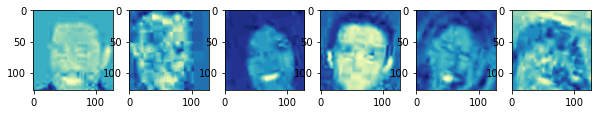

In [84]:
fig, ax = plt.subplots(1, 6, figsize=(10,6))
for inputs in train_ds.take(1):
    for i in range(6):
        ax[i].imshow(inputs[i][:,:,1], cmap = YlBu)
plt.show()

In [93]:
# Use this function to normalize, crop and resize images.
AB_MAX = 127
AB_MIN = -128

# Use this function to normalize, crop and resize images.
def tf_norm_crop_resize_image_x(ele):
    """Normalizes image to [0.,1.], crops to dims (150, 150, 3)
    and resizes to resize_dim, returning an image tensor."""
    resize_dim = (128, 128)
    image = ele
    try:
        image = tf.cast(image, tf.float32)/255.
    except:
        image = tf.cast(image['image'], tf.float32)/255.
    image = tf.image.resize_with_crop_or_pad(image, 150, 150)
    image = tf.image.resize(image, resize_dim)
    image.set_shape(resize_dim + (3,))
    lab = tfio.experimental.color.rgb_to_lab(image)
    l = lab[:,:,0]/100.0
    '''
    uncomment following if using pretrained model
    '''
#     l = tf.expand_dims(l, axis = -1)
#     multiples = tf.constant([3])
#     l = tf.reshape(tf.repeat(l, multiples), (128,128,3))  

    return l

def tf_norm_crop_resize_image_y(ele):
    """Normalizes image to [0.,1.], crops to dims (150, 150, 3)
    and resizes to resize_dim, returning an image tensor."""
    resize_dim = (128, 128)
    image = ele
    try:
        image = tf.cast(image, tf.float32)/255.
    except:
        image = tf.cast(image['image'], tf.float32)/255.
    image = tf.image.resize_with_crop_or_pad(image, 150, 150)
    image = tf.image.resize(image, resize_dim)
    image.set_shape(resize_dim + (3,))
    lab = tfio.experimental.color.rgb_to_lab(image)
    
    ab = tf.reshape((lab[:,:,1:]/128),(128,128,2))
    
    
    return ab

In [94]:
BATCH_SIZE = 64
AUTOTUNE = tf.data.experimental.AUTOTUNE

# Create TF Datasets

image_size = (128,128,3)
train_ds = train_celeb.map(tf_random_rotate_image)
train_x = train_ds.map(tf_norm_crop_resize_image_x)
train_y = train_ds.map(tf_norm_crop_resize_image_y)

train_data = tf.data.Dataset.zip((train_x, train_y))
train_data = train_data.shuffle(buffer_size=10)
train_data = train_data.batch(BATCH_SIZE, drop_remainder=True)
train_data = train_data.prefetch(AUTOTUNE)

# val_ds = val_celeb.map(tf_random_rotate_image)
val_x = val_ds.map(tf_norm_crop_resize_image_x)
val_y = val_ds.map(tf_norm_crop_resize_image_y)

val_data = tf.data.Dataset.zip((val_x, val_y))
val_data = val_data.shuffle(buffer_size=10)
val_data = val_data.batch(BATCH_SIZE, drop_remainder=True)
val_data = val_data.prefetch(AUTOTUNE)

# test_ds = test_celeb.map(tf_random_rotate_image)
test_x = test_ds.map(tf_norm_crop_resize_image_x)
test_y = test_ds.map(tf_norm_crop_resize_image_y)

test_data = tf.data.Dataset.zip((test_x, test_y))
test_data = test_data.shuffle(buffer_size=10)
test_data = test_data.batch(BATCH_SIZE, drop_remainder=True)
test_data = test_data.prefetch(AUTOTUNE)

# drop_remainder = representing whether the last batch should be dropped in the case it has fewer than 
# batch_size elements; the default behavior is not to drop the smaller batch.

In [71]:
for b in train_data.take(1):
    batch = b
    input_l = b[0]
    label_ab = b[1]

In [72]:
tf.reduce_max(input_l)

<tf.Tensor: shape=(), dtype=float32, numpy=0.0027417373>

# Modeling

## Import Pre-Trained Model

In [61]:
# import model pre trained on imagenet
base_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape = (128, 128, 3))
base_model2= Model(inputs=base_model.input, outputs=base_model.layers[-157].output)
base_model2.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 134, 134, 3)  0           ['input_7[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 64, 64, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 64, 64, 64)   256         ['conv1_conv[0][0]']       

In [62]:
# set some layers to non-trainable
for layer in base_model2.layers[:10]:
    layer.trainable = False

## Customized Loss

In [63]:
def custom_loss(y_true, y_pred):
 
    loss = K.abs(y_pred - y_true)
    loss = K.mean(loss, axis=-1)
        
    return 2**(loss)


## Model Architecture

In [95]:
def build_model(inp, use_pretrained):
    if use_pretrained:
        x = base_model2(inp)
    else:
        x = Conv2D(16,(3,3),padding='same',strides=1)(inp)
        x = LeakyReLU()(x)
        x = Conv2D(32,(3,3),padding='same',strides=1)(x)
        x = LeakyReLU()(x)
        x = BatchNormalization()(x)
        x = MaxPooling2D(pool_size=(2,2),padding='same')(x)
        x = Conv2D(64,(3,3),padding='same',strides=1)(x)
        
        x = LeakyReLU()(x)
        x = BatchNormalization()(x)
        x = MaxPooling2D(pool_size=(2,2),padding='same')(x)

        x = Conv2D(128,(3,3),padding='same',strides=1)(x)
        x = LeakyReLU()(x)
        x = BatchNormalization()(x)

        x = Conv2D(256,(3,3),padding='same',strides=1)(x)
        x = LeakyReLU()(x)
        x = BatchNormalization()(x)
    
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(128,(3,3),padding='same',strides=1)(x)
    x = LeakyReLU()(x)
    x = BatchNormalization()(x)
    
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(64,(3,3), padding='same',strides=1)(x)
    x = LeakyReLU()(x)
    x = BatchNormalization()(x)
    
    concat = concatenate([x, inp]) 
    
    x = Conv2D(64,(3,3), padding='same',strides=1)(concat)
    x = LeakyReLU()(x)
    x = BatchNormalization()(x)
    
    x = Conv2D(32,(3,3),padding='same',strides=1)(x)
    x = LeakyReLU()(x)
    x = BatchNormalization()(x)
    
    x = Conv2D(2,(3,3), activation='tanh',padding='same',strides=1)(x)

    return x

## Non-Pretrained Model Fitting

In [96]:
# build model and choose pretrained or not

# non-pretrained model:
H = 128
W = 128
C = 1
use_pretrained = False
if use_pretrained:
    C = 3
Input_Sample = tf.keras.Input(shape=(H, W,C))
Output_ = build_model(Input_Sample, use_pretrained)
model = Model(inputs=Input_Sample, outputs=Output_)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
callbacks_list = [early_stopping]

In [97]:
LEARNING_RATE = 0.001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=LEARNING_RATE),
                            loss=custom_loss)
model.summary()

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_233 (Conv2D)            (None, 128, 128, 16  160         ['input_11[0][0]']               
                                )                                                                 
                                                                                                  
 leaky_re_lu_25 (LeakyReLU)     (None, 128, 128, 16  0           ['conv2d_233[0][0]']             
                                )                                                          

In [98]:
# fit model
history = model.fit(train_data.take(500), validation_data = val_data.take(100), epochs=15,verbose=1, callbacks = callbacks_list)

Epoch 1/15
500/500 [==============================] - 337s 672ms/step - loss: 0.0054 - val_loss: 4.9677e-04
Epoch 2/15
500/500 [==============================] - 368s 736ms/step - loss: 1.3826e-04 - val_loss: 1.2988e-04
Epoch 3/15
500/500 [==============================] - 337s 673ms/step - loss: 1.0781e-04 - val_loss: 9.6093e-05
Epoch 4/15
500/500 [==============================] - 337s 673ms/step - loss: 9.0904e-05 - val_loss: 2.7564e-05
Epoch 5/15
500/500 [==============================] - 336s 671ms/step - loss: 8.1151e-05 - val_loss: 6.2671e-05
Epoch 6/15
500/500 [==============================] - 341s 681ms/step - loss: 6.8886e-05 - val_loss: 6.0259e-05
Epoch 7/15
500/500 [==============================] - 374s 748ms/step - loss: 6.3762e-05 - val_loss: 9.7512e-05
Epoch 7: early stopping


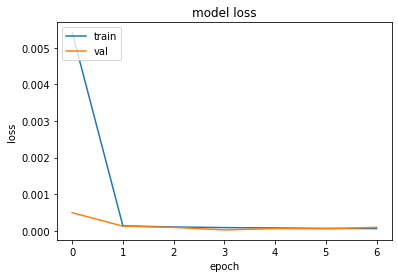

In [99]:
# plot loss history
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Transfer Learning Model Fitting

In [88]:
# pretrained model:
H = 128
W = 128
C = 1
use_pretrained = True
if use_pretrained:
    C = 3
Input_Sample = tf.keras.Input(shape=(H, W,C))
Output_ = build_model(Input_Sample, use_pretrained)
model_pretrained = Model(inputs=Input_Sample, outputs=Output_)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
callbacks_list = [early_stopping]

In [89]:
LEARNING_RATE = 0.001
model_pretrained.compile(optimizer=tf.keras.optimizers.Adam(lr=LEARNING_RATE),
                            loss=custom_loss)
model_pretrained.summary()

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 model_6 (Functional)           (None, 32, 32, 256)  86656       ['input_10[0][0]']               
                                                                                                  
 up_sampling2d_8 (UpSampling2D)  (None, 64, 64, 256)  0          ['model_6[1][0]']                
                                                                                                  
 conv2d_228 (Conv2D)            (None, 64, 64, 128)  295040      ['up_sampling2d_8[0][0]']  

In [90]:
# fit model
history_pretrained = model_pretrained.fit(train_data.take(500), validation_data = val_data.take(100), epochs=15,verbose=1, callbacks = callbacks_list)

Epoch 1/15
500/500 [==============================] - 367s 731ms/step - loss: 0.0048 - val_loss: 3.2550e-04
Epoch 2/15
500/500 [==============================] - 333s 665ms/step - loss: 1.9965e-04 - val_loss: 2.0284e-04
Epoch 3/15
500/500 [==============================] - 335s 668ms/step - loss: 1.2771e-04 - val_loss: 6.5249e-05
Epoch 4/15
500/500 [==============================] - 366s 731ms/step - loss: 1.1552e-04 - val_loss: 1.1835e-04
Epoch 5/15
500/500 [==============================] - 334s 667ms/step - loss: 1.0198e-04 - val_loss: 9.9052e-05
Epoch 6/15
500/500 [==============================] - 366s 731ms/step - loss: 8.2777e-05 - val_loss: 5.6663e-05
Epoch 7/15
500/500 [==============================] - 359s 716ms/step - loss: 8.8564e-05 - val_loss: 1.9529e-04
Epoch 8/15
500/500 [==============================] - 358s 715ms/step - loss: 6.6452e-05 - val_loss: 7.2860e-05
Epoch 9/15
500/500 [==============================] - 357s 714ms/step - loss: 6.7744e-05 - val_loss: 2.5737e

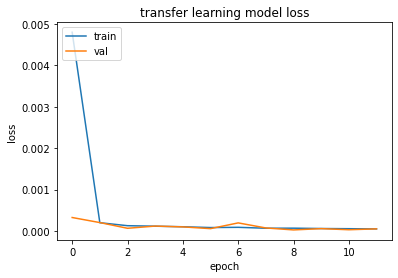

In [92]:
# plot loss history
plt.plot(history_pretrained.history['loss'])
plt.plot(history_pretrained.history['val_loss'])
plt.title('transfer learning model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Results on Test Set

Since both models achieve comparable performance, we made the decision to use the non pre-trained model for evaluation on the test set.

In [419]:
# Take one batch from test set
for b in test_data.take(1):
    batch = b
    input_l = b[0]
    label_ab = b[1]

In [420]:
# Take first example of the batch
test_input, test_output, test_batch = input_l[0], label_ab[0], batch[0]

In [422]:
# if using pretrained:
# test_input = test_input[:,:,0]

In [429]:
# Transform ground truth back to original LAB scale before normalization and concat to obtain LAB
# ground_input = (test_input+0.5)*100.0
# if using pretrained:
ground_input = (test_input)*100.0
# a = tf.reshape(test_output[:,:,0]*(AB_MAX - AB_MIN)+AB_MIN,(128,128,1))
a = tf.reshape(test_output[:,:,0]*128,(128,128,1))
# b = tf.reshape(test_output[:,:,1]*(AB_MAX - AB_MIN)+AB_MIN,(128,128,1))
b = tf.reshape(test_output[:,:,1]*128,(128,128,1))
ground_output = tf.concat([a,b], axis = 2)
ground_lab = tf.concat([tf.reshape(ground_input,shape = (128,128,1)),ground_output], axis=2)

In [430]:
# Obtain prediction for same example in same batch 
y_pred = model.predict(test_batch)[0]

In [435]:
# Transform output {a,b} back to original scale and concat with the input to obtain LAB
y_pred = tf.convert_to_tensor(y_pred)
# a_pred = tf.reshape(y_pred[:,:,0]*(AB_MAX - AB_MIN)+AB_MIN,(128,128,1))
a_pred = tf.reshape(y_pred[:,:,0]*128,(128,128,1))
# b_pred = tf.reshape(y_pred[:,:,1]*(AB_MAX - AB_MIN)+AB_MIN,(128,128,1))
b_pred = tf.reshape(y_pred[:,:,1]*128,(128,128,1))
pred_output = tf.concat([a_pred,b_pred], axis = 2)
pred_lab = tf.concat([tf.reshape(ground_input,shape = (128,128,1)),pred_output], axis=2)

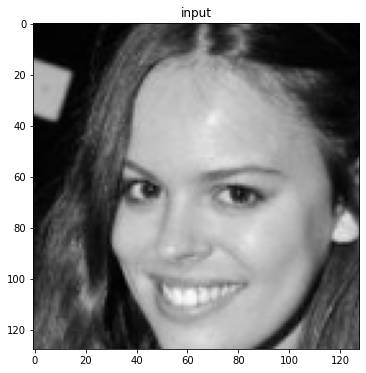

In [447]:
# visualize input 
fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.imshow(ground_input, cmap = 'gray')
ax.set_title('input')
plt.show()

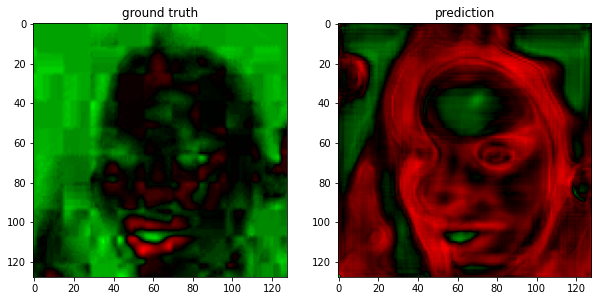

In [448]:
# Compare ground truth to output on a
fig, ax = plt.subplots(1, 2, figsize=(10,6))
ax[0].imshow(ground_lab[:,:,1], cmap = gnrd)
ax[0].set_title('ground truth')
ax[1].imshow(pred_lab[:,:,1], cmap = gnrd)
ax[1].set_title('prediction')
plt.show()

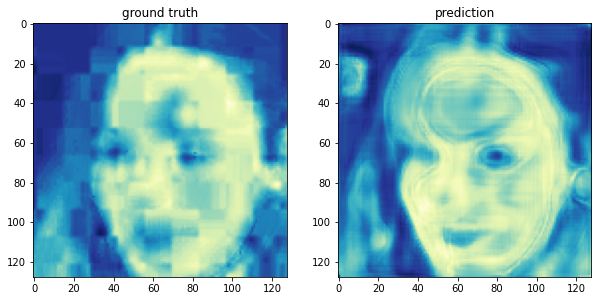

In [449]:
# Compare ground truth to output on b
fig, ax = plt.subplots(1, 2, figsize=(10,6))
ax[0].imshow(ground_lab[:,:,2], cmap = YlBu)
ax[0].set_title('ground truth')
ax[1].imshow(pred_lab[:,:,2], cmap = YlBu)
ax[1].set_title('prediction')
plt.show()

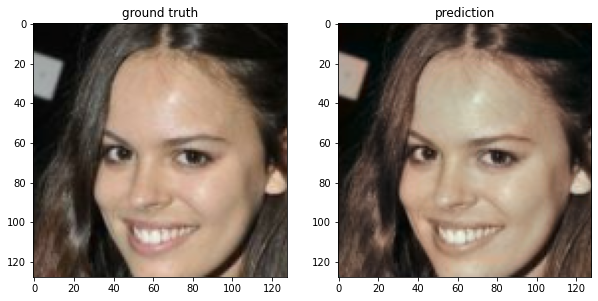

In [450]:
# convert back to RGB and see result
from skimage import io, color

ground_rgb = color.lab2rgb(ground_lab.numpy())
pred_rgb = color.lab2rgb(pred_lab.numpy())

fig, ax = plt.subplots(1, 2, figsize=(10,6))
ax[0].imshow(ground_rgb)
ax[0].set_title('ground truth')
ax[1].imshow(pred_rgb)
ax[1].set_title('prediction')
plt.show()